In [1]:
from utils.load import parse_paf, read_fai
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [14]:
paf = parse_paf('/data/home/sjwan/projects/Y-chromosome/workflow.output/03.assembly.workflow/RY02_Wei_Male_CNUGM0001/T2TY.minimap/ragtag.Y.paf')
paf = paf.drop(paf[paf['target_name']=='*'].index)
# paf = paf[paf['mapping_quality']>=60]
fai = read_fai('/data/home/sjwan/projects/Y-chromosome/workflow.output/data/T2T_Y_subregion.fa.fai')

In [3]:
contigs_name = paf['query_name'].unique().tolist()

In [14]:
# overlap_region = []
# for contig in contigs_name:
#     align = paf[paf['query_name']==contig]
#     for _, row in align.iterrows():
#         for _, region in fai.iterrows():
#             if row['target_start'] <= region['start'] and row['target_end'] >= region['end']:
#                 overlap_region.append([contig, region['contig']])
    

In [2]:
def calculate_usage(df, contig):
    contig_df = df[df['query_name']==contig]
    use_length = contig_df['query_end'] - contig_df['query_start']
    return np.sum(use_length)/np.max(contig_df['query_length'])

In [4]:
def filter_paf(paf):
       keep_col = ['query_name', 'query_length', 'query_start', 'query_end', 'strand',
              'target_name', 'target_length', 'target_start', 'target_end']
       # paf = paf[paf['mapping_quality']>=60]
       align = paf[keep_col]
       align = align.sort_values(by=['query_start'],ascending=False)

       align['start_diff'] =( align['query_start']/align['query_length']) - (align['target_start']/align['target_length'] )
       align['end_diff'] = (align['query_end']/align['query_length']) - (align['target_end']/align['target_length']) 
       align['query_start_percent'] = align['query_start']/align['query_length']
       align['query_end_percent'] = align['query_end']/align['query_length']
       align['target_start_percent'] = align['target_start']/align['target_length']
       align['target_end_percent'] = align['target_end']/align['target_length']
       align['MB'] = (align['target_end'] - align['target_start'])/1e6
       return align

In [5]:
import matplotlib 
from collections import defaultdict
from matplotlib.colors import ListedColormap


def plot_reads_cover(fai, plot_align, sample, out_fig):
    plt.figure(figsize=(14, 8))
    ref_colors = ListedColormap(plt.cm.tab20.colors[:len(fai)])
    num_queries = plot_align['query_name'].nunique()
    contig_total_length = plot_align.groupby('query_name')['MB'].sum().sort_values(ascending=False)
    # 选择总体比对长度前五的 contig
    top_contigs = contig_total_length.head(5).index
    contig_colors = plt.cm.rainbow(np.linspace(0, 1, num_queries))
    for i, row in fai.iterrows():
        plt.plot([row['start'], row['end']], [-1000000, -1000000], marker='|', color=ref_colors(i))
    # 动态分配 y 轴位置
    y_positions = defaultdict(list)
    max_y = 15  # 初始最大 y 位置
    query_names = plot_align['query_name'].unique()
    query_color_map = {query_name: contig_colors[i] for i, query_name in enumerate(query_names)}
    # 分配给每个 query_name 的颜色
    query_names = plot_align['query_name'].unique()
    query_color_map = {query_name: contig_colors[i] for i, query_name in enumerate(query_names)}
    # 颜色映射
    top_colors = plt.cm.tab10(np.linspace(0, 1, 5))  # 前五个 contigs 使用 tab10 的前五种颜色
    other_colors = plt.cm.rainbow(np.linspace(0, 1, max(len(plot_align['query_name'].unique()) - 5, 0)))  # 其他 contigs 使用 rainbow 颜色
    query_color_map = {}
    for i, query_name in enumerate(plot_align['query_name'].unique()):
        if query_name in top_contigs:
            query_color_map[query_name] = top_colors[list(top_contigs).index(query_name)]
        else:
            query_color_map[query_name] = other_colors[len(query_color_map) - len(top_contigs)]

    # 绘制比对结果
    for i, row in plot_align.iterrows():
        contig_color = query_color_map[row['query_name']]
        query_start = row['query_start']
        query_end = row['query_end']
        if row['strand'] == '-':
            query_start, query_end = query_end, query_start  # 反转方向
        plt.plot([row['target_start'], row['target_end']], [query_start, query_end], marker='o', color=contig_color,
                 label=row['query_name'] if row['query_name'] in top_contigs else "")

    # 添加图例
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # 只保留前五个 contig 的图例
    top_handles = [by_label[label] for label in top_contigs]
    top_labels = top_contigs
    plt.legend(top_handles, top_labels, title="Top 5 Contigs by Alignment Length")

    # 调整 y 轴范围以适应所有比对结果
    plt.ylim(-2000000, plot_align[['query_start', 'query_end']].max().max() + 2000000)
    plt.xlim(-2000000, plot_align['target_end'].max() + 2000000)

    # 调整 y 轴范围以适应所有比对结果
    # plt.ylim(-1, max_y + 1)
    # 添加标题和标签
    plt.title(f'Dotplot of {sample} Minimap Alignments')
    plt.xlabel('Position')
    plt.ylabel('Alignments')
    plt.grid(True)
    plt.savefig(out_fig)
    plt.show()

In [6]:
import os
data_dir = '/data/home/sjwan/projects/Y-chromosome/workflow.output/data/verkko1.4'
sample_list = os.listdir(data_dir)
sample_list = sorted(sample_list)
# for sample in sample_list:
#     out_fig = f'/data/home/sjwan/projects/Y-chromosome/workflow.output/03.assembly.workflow/img/minimap.Y.{sample}.png'
#     paf = parse_paf(f'/data/home/sjwan/projects/Y-chromosome/workflow.output/03.assembly.workflow/{sample}/T2TY.minimap/ragtag.Y.paf')
#     plot_align = filter_paf(paf)
#     plot_align = plot_align[plot_align['MB']>=0.2].sort_values(by=['MB'], ascending=False)
#     plot_reads_cover(fai, plot_align, sample,out_fig)
 

In [31]:
keep_contigs = {}
for sample in sample_list:
    paf = parse_paf(f'/data/home/sjwan/projects/Y-chromosome/workflow.output/03.assembly.workflow/{sample}/T2TY.minimap/ragtag.Y.paf')
    plot_align = filter_paf(paf)
    contig_total_length = plot_align.groupby('query_name')['MB'].sum().sort_values(ascending=False)
    top_contigs = contig_total_length.head(10).index
    keep_contigs[sample] = list(top_contigs)

In [33]:
from utils.fasta import extract_contigs
for sample in sample_list:
    contigs = f'/data/home/sjwan/projects/Y-chromosome/workflow.output/data/verkko1.4/{sample}/contigs.ragtag.Y.fasta'
    out_contigs = f'/data/home/sjwan/projects/Y-chromosome/workflow.output/data/verkko1.4/{sample}/contigs.max10.Y.fasta'
    extract_contigs(contigs, out_contigs,keep_contigs[sample])

In [21]:
regions_name = fai['contig'].unique().tolist()


In [22]:
all_count = {}
for sample in sample_list:
    overlap_region = []
    paf = parse_paf(f'/data/home/sjwan/projects/Y-chromosome/workflow.output/03.assembly.workflow/{sample}/T2TY.minimap/ragtag.Y.paf')
    plot_align = filter_paf(paf)
    for idx, row in plot_align.iterrows():
        for _, region in fai.iterrows():
            if row['target_start'] <= region['start'] and row['target_end'] >= region['end']:
                overlap_region.append([contig, region['contig']])
    all_count[sample] = overlap_region
    print(overlap_region)

[['unassigned-0002298', 'chrY_HET1_centro1'], ['unassigned-0002298', 'chrY_HET1_centro1'], ['unassigned-0002298', 'chrY_HET1_centro1'], ['unassigned-0002298', 'chrY_HET1_centro1'], ['unassigned-0002298', 'chrY_XDR1'], ['unassigned-0002298', 'chrY_XTR1'], ['unassigned-0002298', 'chrY_AMPL1'], ['unassigned-0002298', 'chrY_XTR2'], ['unassigned-0002298', 'chrY_XDR2'], ['unassigned-0002298', 'chrY_other1'], ['unassigned-0002298', 'chrY_HET1_centro1'], ['unassigned-0002298', 'chrY_XDR3'], ['unassigned-0002298', 'chrY_AMPL3'], ['unassigned-0002298', 'chrY_XDR4'], ['unassigned-0002298', 'chrY_AMPL4'], ['unassigned-0002298', 'chrY_XDR5'], ['unassigned-0002298', 'chrY_AMPL5'], ['unassigned-0002298', 'chrY_XDR6'], ['unassigned-0002298', 'chrY_XDR7'], ['unassigned-0002298', 'chrY_HET2_DYZ19'], ['unassigned-0002298', 'chrY_XDR8'], ['unassigned-0002298', 'chrY_other1'], ['unassigned-0002298', 'chrY_HET1_centro1'], ['unassigned-0002298', 'chrY_other1'], ['unassigned-0002298', 'chrY_HET1_centro1'], ['

In [24]:
regions_name = [name.split('_')[1] for name in regions_name]

In [25]:
continue_array = np.zeros([len(sample_list), len(regions_name)])
continue_df = pd.DataFrame(continue_array, columns=regions_name)
for idx, sample in enumerate(sample_list):
    regions = all_count[sample]
    for region in regions:
        continue_df.loc[idx,region[1].split('_')[1]] = 1
continue_df.index = sample_list

In [26]:
continue_df.to_csv('assemblies.regions.csv')

In [7]:
def filter_gap(cover_array):
    gaps = []
    start = 0
    end = 0
    while start <= cover_array.shape[0]:
        if cover_array[end] == 1:
            end+=1
            

def count_contigs_coverage(paf_df):
    unique_name = paf_df['query_name'].unique()
    line = []
    for name in unique_name:
        part_df = paf_df[paf_df['query_name']==name]
        cover = np.zeros(part_df['query_length'].max()+1,dtype=np.int8)
        min_start = part_df['target_start'].min()
        max_end = part_df['target_end'].max()
        for idx, row in part_df.iterrows():
            cover[int(row['query_start']):int(row['query_end'])] = 1
        ref_coverage = (max_end - min_start)/part_df['query_length'].max()
        line.append([name, part_df['query_length'].max(),np.mean(cover), min_start, max_end, ref_coverage])
    return pd.DataFrame(line, columns=['contig','length','cover','ref_start','ref_end','ref_coverage'])

In [15]:
cover_df =  count_contigs_coverage(paf)

In [16]:
cover_df[cover_df['cover']>=0.8].sort_values(by=['length'],ascending=False).head(25).sort_values(by=['ref_start'])

,contig,length,cover,ref_start,ref_end,ref_coverage
48,haplotype2-0000666,54977839,0.969785,0,62460029,1.136095
10,haplotype1-0000031,974225,0.993788,0,1009835,1.036552
59,haplotype2-0000686,280319,0.999633,1085253,1371467,1.021030
60,haplotype2-0000687,281585,0.999634,1086871,1371045,1.009194
74,haplotype2-0000732,130585,0.999992,1410286,1540242,0.995183
69,haplotype2-0000722,342875,0.999519,1543922,1889038,1.006536
70,haplotype2-0000723,342486,0.999936,1545848,1888377,1.000126
71,haplotype2-0000724,108339,0.999991,1880835,1989462,1.002658
76,haplotype2-0000734,294652,0.999997,10570352,10872152,1.024259
65,haplotype2-0000715,35110,0.999972,10571983,10717006,4.130533


In [57]:
from sklearn.cluster import DBSCAN
from matplotlib.colors import Normalize

# 计算偏移量 b，考虑正链和反链的情况
def calculate_b(row):
    try:
        if row['strand'] == '+':
            return (row['target_start']/row['target_length'] - row['query_start']/row['query_length'])
        else:
            return (row['target_end']/row['target_length'] - row['query_start']/row['query_length'])
    except ZeroDivisionError:
        print(row)

def calculate_d(row):
    try:
        if row['strand'] == '+':
            return (row['target_end']/row['target_length'] - row['query_end']/row['query_length'])
        else:
            return (row['target_start']/row['target_length'] - row['query_end']/row['query_length'])
    except ZeroDivisionError:
        print(row)
    
    
def cluster_most_coverage(paf_df, contig_names):
    line = []
    for name in contig_names:
        part_df = paf_df[paf_df['query_name'] == name].copy()
        part_df['b'] = part_df.apply(calculate_b, axis=1)
        cover = np.zeros(part_df['query_length'].max() + 1, dtype=np.int8)
        min_start = part_df['target_start'].min()
        max_end = part_df['target_end'].max()
        for idx, row in part_df.iterrows():
            cover[int(row['query_start']):int(row['query_end'])] = 1
        if np.mean(cover) < 0.9 and part_df['query_length'].max() <= 1000000:
            continue
        
        # 使用DBSCAN进行聚类
        eps = 0.005  # 需要根据数据特点调整
        min_samples = 2  # 需要根据数据特点调整
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        part_df.loc[part_df.index, 'cluster'] = dbscan.fit_predict(part_df[['b']])
        
        print(name, part_df['cluster'].unique())
        if (np.sum(part_df['cluster'] == -1) / part_df.shape[0]) >= 0.5:
            continue
        # part_df['b'].hist()
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # 定义多个色系
        color_maps = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]
        cluster_color_map = {}
        cluster_lines = {}  # 用于保存每个簇的Line2D对象，以便在图例中显示

        cluster_ids = sorted(part_df['cluster'].unique())
        for i, cluster in enumerate(cluster_ids):
            cluster_color_map[cluster] = color_maps[i % len(color_maps)]
        
        for idx, row in part_df.iterrows():
            cluster = row['cluster']
            cmap = cluster_color_map[cluster]
            color = cmap(0.5)  # 取颜色图的中间颜色
            line_style = 'solid' if row['strand'] == '+' else 'dashed'
            line, = plt.plot(
                [row['query_start'], row['query_end']], 
                [row['target_start'], row['target_end']] if row['strand'] == '+' else [row['target_end'], row['target_start']], 
                color=color, linestyle=line_style,
                label=f'Cluster {cluster}' if cluster not in cluster_lines else ""
            )
            if cluster not in cluster_lines:
                cluster_lines[cluster] = line
        
        # 添加图例
        handles, labels = [], []
        for cluster, line in cluster_lines.items():
            handles.append(line)
            labels.append(f'Cluster {cluster}')
        ax.legend(handles=handles, labels=labels, title='Clusters', loc='upper right')
        
        ax.set_xlabel('Query Start')
        ax.set_ylabel('Target Start')
        ax.set_title('DBSCAN Clustering of Alignments Based on Offset b')
        plt.savefig(f'/data/home/sjwan/projects/Y-chromosome/tmp/{name}.png')
        plt.close()
        # return None
        

In [43]:
cluster_most_coverage(paf,cover_df['contig'].unique())

haplotype1-0000004 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. -1. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53.]
haplotype1-0000007 [-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]
haplotype1-0000009 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. -1. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.]
haplotype1-0000011 [ 0.  1.  2. -1.  3.  4.  5.  6.  7.  8.  9.]
haplotype1-0000017 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. -1. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.

In [115]:
# paf[paf['target_name']=='*']
df_clean = paf.drop(paf[paf['target_name']=='*'].index)

In [58]:
def cluster_all_diff(paf_df):
    part_df = paf_df.copy()
    part_df['b'] = part_df.apply(calculate_b, axis=1)
    part_df['d'] = part_df.apply(calculate_d, axis=1)
    # 使用DBSCAN进行聚类
    eps = 0.05  # 需要根据数据特点调整
    min_samples = 3  # 需要根据数据特点调整
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    part_df.loc[part_df.index, 'cluster'] = dbscan.fit_predict(part_df[['b','d']])
    # part_df['b'].hist()
    fig, ax = plt.subplots(figsize=(10, 6))

    # 定义多个色系
    color_maps = [plt.cm.viridis, plt.cm.plasma, plt.cm.inferno, plt.cm.magma, plt.cm.cividis]
    cluster_color_map = {}
    cluster_lines = {}  # 用于保存每个簇的Line2D对象，以便在图例中显示

    cluster_ids = sorted(part_df['cluster'].unique())
    for i, cluster in enumerate(cluster_ids):
        cluster_color_map[cluster] = color_maps[i % len(color_maps)]

    for idx, row in part_df.iterrows():
        cluster = row['cluster']
        cmap = cluster_color_map[cluster]
        color = cmap(0.5)  # 取颜色图的中间颜色
        line_style = 'solid' if row['strand'] == '+' else 'dashed'
        line, = plt.plot(
            [row['query_start'], row['query_end']],
            [row['target_start'], row['target_end']] if row['strand'] == '+' else [row['target_end'], row['target_start']],
            color=color, linestyle=line_style,
            label=f'Cluster {cluster}' if cluster not in cluster_lines else ""
        )
        if cluster not in cluster_lines:
            cluster_lines[cluster] = line

    # 添加图例
    handles, labels = [], []
    for cluster, line in cluster_lines.items():
        handles.append(line)
        labels.append(f'Cluster {cluster}')
    ax.legend(handles=handles, labels=labels, title='Clusters', loc='upper right')

    ax.set_xlabel('Query Start')
    ax.set_ylabel('Target Start')
    ax.set_title('DBSCAN Clustering of Alignments Based on Offset b')
    plt.savefig(f'/data/home/sjwan/projects/Y-chromosome/tmp/all.png')
    plt.close()
    return part_df

In [59]:
res = cluster_all_diff(paf)

array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'd'}>]],
      dtype=object)

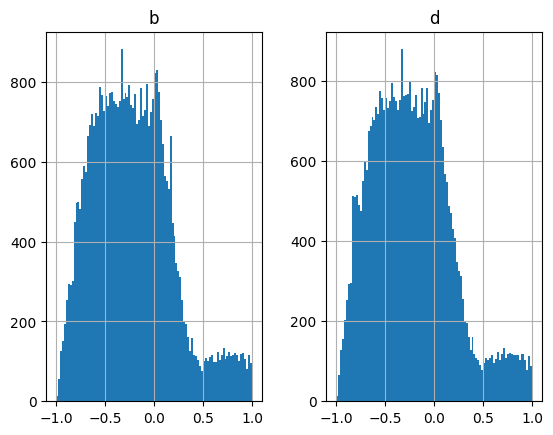

In [60]:
res[['b','d']].hist(bins=100)